<a href="https://colab.research.google.com/github/itzahs/GeoPythonWorkshop2023_SSL/blob/main/1_GetData_SSL_for_aerial_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GeoPython 2023 Workshop

## Section 1: Download the UCM dataset & understand augmentations
## Section 2: Implementation of the FixMatch algorithm using PyTorch 

### Import required packages and libraries 


In [ ]:
# Built-in modules
import os
import zipfile

# Third-party modules
import numpy as np
import urllib.request
import random
from PIL import Image
from PIL import TiffImagePlugin
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import tempfile


# Local modules
from google.colab import drive

### Set up working folder

In [ ]:
# Mount google drive
drive.mount('/content/drive')

# Create working folder 
folder_name = "GeoPythonWorkshop_SSL"
path_to_folder = "/content/drive/MyDrive/" + folder_name

if not os.path.exists(path_to_folder):
    os.makedirs(path_to_folder)
    print(F"Folder '{folder_name}' has been created successfully.")
else:
    print(F"Folder '{folder_name}' already exists.")

# Set working folder as default
%cd "/content/drive/MyDrive/GeoPythonWorkshop_SSL"

Mounted at /content/drive
Folder 'GeoPythonWorkshop_SSL' has been created successfully.
/content/drive/MyDrive/GeoPythonWorkshop_SSL


### Download the UCM dataset 

In [ ]:
# URL where data is stored
data_url = 'http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip'
zip_file_path = 'UCMerced_LandUse.zip'
data_dir_path = 'UCMerced_LandUse'

# Downloading the UCM dataset
if not os.path.exists(zip_file_path):
    print(f"Downloading {data_url}...")
    urllib.request.urlretrieve(data_url, zip_file_path)

# Unzipping the UCM dataset
if not os.path.exists(data_dir_path):
    print(f"Unzipping {zip_file_path}...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('.')

Unzipping UCMerced_LandUse.zip...


In [ ]:
# Checking that out data was correctly extracted
!ls

UCMerced_LandUse  UCMerced_LandUse.zip


### Create train and test files

In [ ]:
# Define the base path for the image folders
root_dir = 'UCMerced_LandUse/Images'

# Get subfolders path
folders = sorted([f.path for f in os.scandir(root_dir) if f.is_dir()])

# Create dictionary where each subfolder has a value
classes_dict = {}
for i, folder in enumerate(folders):
    folder_name = os.path.basename(folder)
    classes_dict[folder_name] = i
print(classes_dict)

# From the dictionary get the classes as list
classes = list(classes_dict.keys())
print(classes)

{'agricultural': 0, 'airplane': 1, 'baseballdiamond': 2, 'beach': 3, 'buildings': 4, 'chaparral': 5, 'denseresidential': 6, 'forest': 7, 'freeway': 8, 'golfcourse': 9, 'harbor': 10, 'intersection': 11, 'mediumresidential': 12, 'mobilehomepark': 13, 'overpass': 14, 'parkinglot': 15, 'river': 16, 'runway': 17, 'sparseresidential': 18, 'storagetanks': 19, 'tenniscourt': 20}
['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


In [ ]:
# Define paths for train and test files
train_file = open("UCMerced_LandUse/Images/UCM_train.txt", "w")
test_file = open("UCMerced_LandUse/Images/UCM_test.txt", "w")

# Define split percentage 
split = 0.5

# Define seed for random shuffle 
seed = 123

# Loop through folders 
for foldername in os.listdir(root_dir):
    if not os.path.isdir(os.path.join(root_dir, foldername)):
        continue  # skip files
    # Get list of files on each folder and class 
    class_id = classes_dict[foldername]
    file_list = os.listdir(os.path.join(root_dir, foldername))
    # Shuffle the file list with a fixed seed for reproducibility
    random.seed(seed)
    random.shuffle(file_list)
    # Get number of files for each folder and create the split
    num_files = len(file_list)
    train_count = int(num_files * split)
    test_count = num_files - train_count
    # Write the files 
    for filename in file_list[:train_count]:
        path = os.path.join(root_dir, foldername, filename)
        train_file.write(f"{path} {class_id}\n")
    for filename in file_list[train_count:]:
        path = os.path.join(root_dir, foldername, filename)
        test_file.write(f"{path} {class_id}\n")

# Close files
train_file.close()
test_file.close()

In [ ]:
train_file = open("UCMerced_LandUse/Images/UCM_train.txt", "r")
test_file = open("UCMerced_LandUse/Images/UCM_test.txt", "r")

# Initialize a counter for each class at 0 
train_counts = {class_: 0 for class_ in classes}
test_counts = {class_: 0 for class_ in classes}

# For every line that contains the class name, add 1
for line in train_file:
    image_path, class_int = line.strip().split()
    class_ = image_path.split("/")[-2]
    train_counts[class_] += 1

for line in test_file:
    image_path, class_int = line.strip().split()
    class_ = image_path.split("/")[-2]
    test_counts[class_] += 1

train_file.close()
test_file.close()

# Print how many images are in each txt file
print("Train Counts:")
for class_ in classes:
    print(f"{class_}: {train_counts[class_]}")

print("\nTest Counts:")
for class_ in classes:
    print(f"{class_}: {test_counts[class_]}")


Train Counts:
agricultural: 50
airplane: 50
baseballdiamond: 50
beach: 50
buildings: 50
chaparral: 50
denseresidential: 50
forest: 50
freeway: 50
golfcourse: 50
harbor: 50
intersection: 50
mediumresidential: 50
mobilehomepark: 50
overpass: 50
parkinglot: 50
river: 50
runway: 50
sparseresidential: 50
storagetanks: 50
tenniscourt: 50

Test Counts:
agricultural: 50
airplane: 50
baseballdiamond: 50
beach: 50
buildings: 50
chaparral: 50
denseresidential: 50
forest: 50
freeway: 50
golfcourse: 50
harbor: 50
intersection: 50
mediumresidential: 50
mobilehomepark: 50
overpass: 50
parkinglot: 50
river: 50
runway: 50
sparseresidential: 50
storagetanks: 50
tenniscourt: 50


### Create the dataset class from the text files 

In [ ]:
""" The Code is under Tencent Youtu Public Rule"""
#val，l-train dataset
class MyDataset(Dataset):
    """
    Interface provided for customized data sets

    names_file：a txt file, each line in the form of "image_path label"

    transform: transform pipline for mydataset

    """
    def __init__(self, names_file, transform=None):
        self.names_file = names_file
        self.transform = transform
        self.size = 0
        self.names_list = []

        file = open(self.names_file)
        for f in file:
            self.names_list.append(f)
            self.size += 1

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        image_path = self.names_list[idx].split(' ')[0]
        image = Image.open(image_path)
        if(image.mode == 'L'):
            image = image.convert('RGB')
        label = int(self.names_list[idx].split(' ')[1])

        if self.transform:
            image = self.transform(image)

        return image, label

0


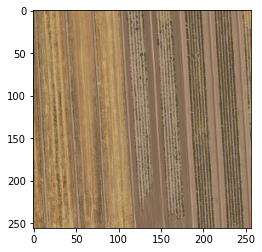

In [ ]:
# Create an instance of the dataset with no transformations 
names_file = './UCMerced_LandUse/Images/UCM_train.txt'
dataset = MyDataset(names_file, transform=None)

# Access individual images and their labels by indexing the dataset object
image, label = dataset[0]

# Display image and label 
print(label)  
plt.imshow(image)

0


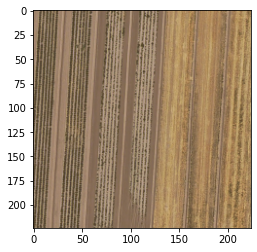

In [ ]:
# Create an instance of the dataset with weak transformation 
names_file = './UCMerced_LandUse/Images/UCM_train.txt'
transform_w = transforms.Compose([
                       transforms.RandomHorizontalFlip(p=0.5), 
                       transforms.Resize(size=256),
                       transforms.CenterCrop(size=224),    
                       transforms.ToTensor()
                       #skip normalization or original RGB colors will not display properly    
                       #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                       ])
dataset_w = MyDataset(names_file, transform=transform_w)

# Access individual images and their labels by indexing the dataset object
image_w, label_w = dataset_w[0]

# Get the tensor of shape [3, 224, 224] back to PIL.TiffImage format  
image_array = image_w.cpu().numpy().transpose(1, 2, 0)
image_pil = Image.fromarray(np.uint8(image_array * 255))

# Save the image as a temporary TIFF file
with tempfile.NamedTemporaryFile(suffix='.tiff') as tmp:
    image_pil.save(tmp.name)
    tmp.flush()
    # Open the temporary TIFF file as a TiffImageFile
    image_tiff = TiffImagePlugin.TiffImageFile(tmp.name)

# Display image and label 
print(label_w)  
plt.imshow(image_tiff)

0


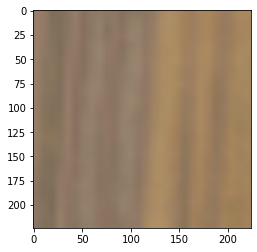

In [ ]:
# Create an instance of the dataset with strong transformation 
names_file = './UCMerced_LandUse/Images/UCM_train.txt'
transform_s = transforms.Compose([
                          transforms.RandomResizedCrop(size=32),
                          transforms.RandomHorizontalFlip(p=0.5),
                          transforms.RandomApply([
                              transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)
                              ], p=0.3),
                          transforms.Resize(size=256),
                          transforms.CenterCrop(size=224),
                          transforms.ToTensor()
                          ])

dataset_s = MyDataset(names_file, transform=transform_s)

# Access individual images and their labels by indexing the dataset object
image_s, label_s = dataset_s[0]

# Get the tensor of shape [3, 224, 224] back to PIL.TiffImage format  
image_array = image_s.cpu().numpy().transpose(1, 2, 0)
image_pil = Image.fromarray(np.uint8(image_array * 255))

# Save the image as a temporary TIFF file
with tempfile.NamedTemporaryFile(suffix='.tiff') as tmp:
    image_pil.save(tmp.name)
    tmp.flush()
    # Open the temporary TIFF file as a TiffImageFile
    image_tiff = TiffImagePlugin.TiffImageFile(tmp.name)

# Display image and label 
print(label_s)  
plt.imshow(image_tiff)